In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [65]:
WIDTH = 360
HEIGHT = 480
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE
)

Found 2906 files belonging to 4 classes.


In [13]:
class_names = dataset.class_names
class_names

['Boys-Apparel', 'Boys-Footwear', 'Girls-Apparel', 'Girls-Footwear']

In [14]:
len(dataset)

91

In [15]:
91 * 32

2912

In [16]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)  
    print(label_batch.numpy())

(32, 360, 480, 3)
[1 1 3 0 2 1 0 3 1 0 0 3 0 1 1 0 2 2 3 0 2 1 3 2 1 3 3 2 1 1 3 2]


In [28]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[3].numpy())

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


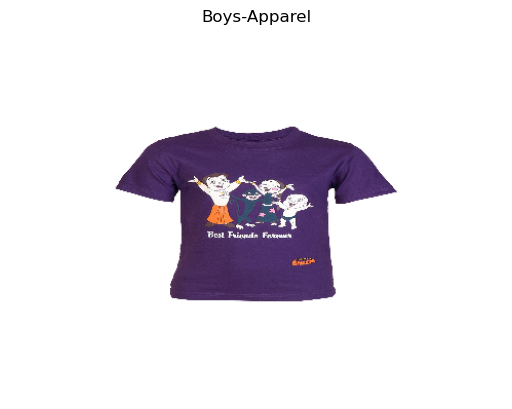

In [29]:
for image_batch, label_batch in dataset.take(1):
    first_image = image_batch[1].numpy().astype("uint8")

    plt.imshow(first_image)
    plt.title(class_names[label_batch[1]])
    plt.axis("off") 
    plt.show()


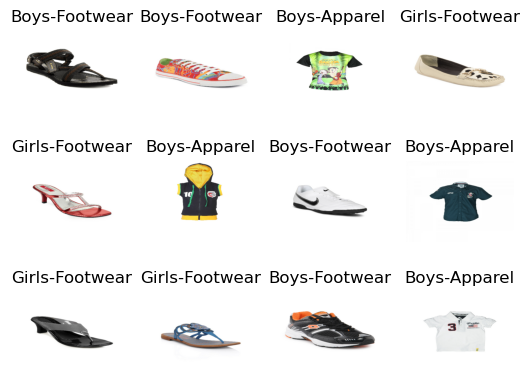

In [34]:
# plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        first_image = image_batch[i].numpy().astype("uint8")

        plt.imshow(first_image)
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 
    plt.show()

In [35]:
len(dataset)

91

In [37]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [38]:
train_size = 0.8
len(dataset) * train_size

72.8

In [40]:
train_ds = dataset.take(72)
len(train_ds)

72

In [41]:
test_ds = dataset.skip(72)
len(test_ds)

19

In [42]:
val_size = 0.1
len(dataset)*val_size

9.1

In [44]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [45]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [46]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [47]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [48]:
len(train_ds)

72

In [49]:
len(test_ds)

9

In [50]:
len(val_ds)

10

In [51]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
# resize_and_rescale = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(WIDTH, HEIGHT),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
# ])

In [56]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(height=HEIGHT, width=WIDTH),  
    layers.Rescaling(1./255)
])

In [57]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  
    layers.RandomRotation(0.2)
])

In [59]:
input_shape = (BATCH_SIZE, WIDTH, HEIGHT, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Adekunle Habeeb\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 480, 360, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 478, 358, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 239, 179, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 237, 177, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 118, 88, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 116, 86, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 58, 43, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 56, 41, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 28, 20, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 26, 18, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 13, 9, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 11, 7, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 5, 3, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 960)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,868 (894.02 KB)

 Trainable params: 228,868 (894.02 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 794s 9s/step - accuracy: 0.4612 - loss: 1.1292 - val_accuracy: 0.6732 - val_loss: 0.6825
Epoch 2/50
50/72 ━━━━━━━━━━━━━━━━━━━━ 2:36 7s/step - accuracy: 0.7313 - loss: 0.5491


KeyboardInterrupt

